In [14]:
!pip install transformers torch
!pip install contractions
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9dd0e066f06620ceb7f1fea7dc6d9333b362203660c03b481c543b62569aa0aa
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline, BartForConditionalGeneration, BartTokenizer
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
data = pd.read_csv('digital_video_games.csv', encoding='ISO-8859-1')
reviews = data[['product_parent', 'product_title', 'review_body', 'star_rating']].dropna()

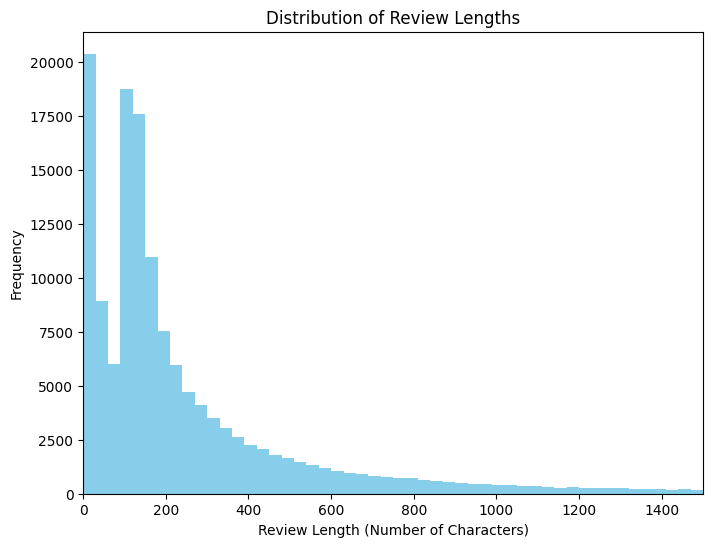

In [5]:
import matplotlib.pyplot as plt
reviews['review_length'] = reviews['review_body'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(reviews['review_length'], bins=50, color='skyblue', range=(0, 1500))
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Frequency')
plt.xlim(0, 1500)
plt.show()

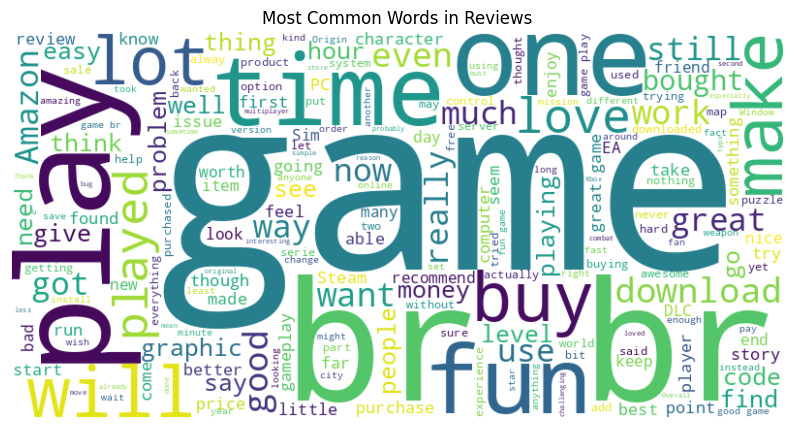

In [7]:
from wordcloud import WordCloud
all_reviews_text = ' '.join(reviews['review_body'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', '', text)
    words = word_tokenize(text)
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(processed_words).strip()

In [10]:
qa_pipeline = pipeline('question-answering', model='deepset/roberta-base-squad2')  # RoBERTa for question-answering
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

def answer_question(question, context):
    result = qa_pipeline({'question': question, 'context': context})
    return result['answer']

def preprocess_input(question, review_body):
    processed_question = preprocess_text(question)
    processed_review = preprocess_text(review_body)
    return processed_question, processed_review

def summarize_combined_answer(combined_answer):
    inputs = bart_tokenizer.encode("Summarized answer: " + combined_answer, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = bart_model.generate(inputs, max_length=80, min_length=20, length_penalty=2.0, num_beams=5, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def extract_and_summarize_for_product(question, product_parent, reviews, max_reviews=10):
    product_reviews = reviews[reviews['product_parent'] == product_parent]
    if product_reviews.empty:
        return "No reviews found for the specified product."
    processed_reviews = product_reviews['review_body'].apply(preprocess_text).tolist()
    processed_question = preprocess_text(question)
    all_texts = processed_reviews + [processed_question]
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)
    question_vector = tfidf_matrix[-1]
    review_vectors = tfidf_matrix[:-1]
    similarities = cosine_similarity(question_vector, review_vectors).flatten()
    ranked_indices = similarities.argsort()[::-1]
    relevant_reviews = [processed_reviews[i] for i in ranked_indices[:max_reviews]]
    all_answers = []
    for i, review in enumerate(relevant_reviews):
        try:
            extracted_answer = answer_question(question, review)
            cleaned_answer = preprocess_text(extracted_answer)
            all_answers.append(cleaned_answer)
        except Exception as e:
            print(f"Error processing review {i}: {str(e)}")
            continue
    if not all_answers:
        return "No relevant information found in the reviews."
    combined_answer = '. '.join(all_answers)
    final_summary = summarize_combined_answer(combined_answer)
    return final_summary

In [11]:
user_question = "What do users think about the product?"
product_parent = 341969535
final_summary = extract_and_summarize_for_product(user_question, product_parent, reviews)
print(final_summary)

Summarized answer: internet worker might need step away. work yay. great product. greatProduct.


In [17]:
from rouge_score import rouge_scorer
true_summary = "Great product. Great for workers. May need a break occasionally."
predicted_summary = "internet worker might need step away. work yay. great product. greatProduct."
def calculate_rouge(predicted_summary, true_summary):
    scorer = rouge_scorer.RougeScorer(rouge_types=['rouge1', 'rouge2', 'rougeL'])
    scores = scorer.score(true_summary, predicted_summary)
    return scores
rouge_scores = calculate_rouge(predicted_summary, true_summary)

print("ROUGE-1: ", rouge_scores['rouge1'])
print("ROUGE-2: ", rouge_scores['rouge2'])
print("ROUGE-L: ", rouge_scores['rougeL'])

ROUGE-1:  Score(precision=0.2727272727272727, recall=0.3, fmeasure=0.28571428571428564)
ROUGE-2:  Score(precision=0.1, recall=0.1111111111111111, fmeasure=0.10526315789473685)
ROUGE-L:  Score(precision=0.18181818181818182, recall=0.2, fmeasure=0.1904761904761905)


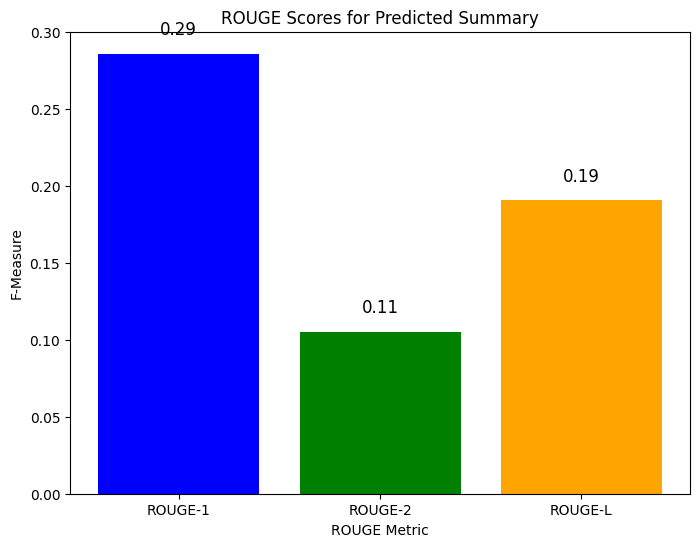

In [19]:
def plot_rouge_scores(rouge_scores):
    rouge_1_fmeasure = rouge_scores['rouge1'].fmeasure
    rouge_2_fmeasure = rouge_scores['rouge2'].fmeasure
    rouge_l_fmeasure = rouge_scores['rougeL'].fmeasure
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    values = [rouge_1_fmeasure, rouge_2_fmeasure, rouge_l_fmeasure]
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'green', 'orange'])
    plt.xlabel('ROUGE Metric')
    plt.ylabel('F-Measure')
    plt.title('ROUGE Scores for Predicted Summary')
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=12)
    plt.show()
plot_rouge_scores(rouge_scores)